In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [3]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [4]:
from models.CRNN import CRNN_model

# 1. Data

In [6]:
strategy = CommodityStrategy(strategy_name="CPM", asset_type="COMMODITY")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

2019-10-30 19:56:20,392 - CPM - INFO - [STEP 0] START LOGGING CPM
2019-10-30 19:56:20,393 - CPM - INFO - [STEP 1] LOAD DATA


AttributeError: 'NoneType' object has no attribute 'columns'

In [27]:
df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

# 2. Explore

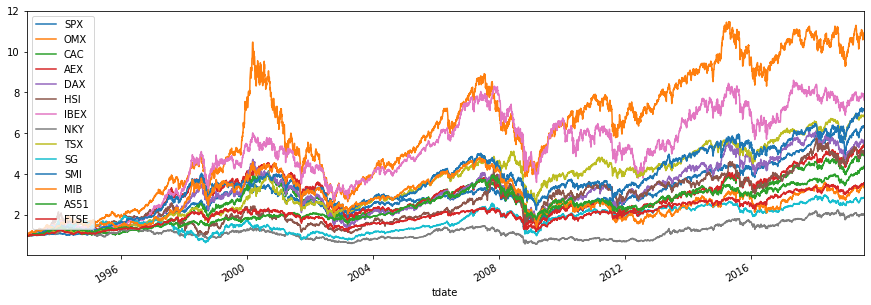

In [28]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

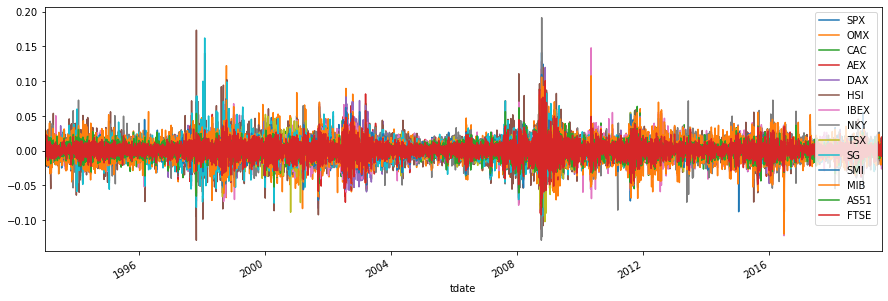

In [29]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

### CROSS SECTIONAL

In [30]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 189, 252]

## 1. X

### average return

In [31]:
avg_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_ret['avg_ret_' + str(period)] = df_index_return.rolling(period).mean()

### average vol

In [32]:
avg_vol  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_vol['avg_vol_' + str(period)] = df_index_return.rolling(period).std()

### cum return

In [33]:
cum_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    cum_ret['cum_ret_' + str(period)] = df_index.pct_change(period)

In [34]:
df_mom_avg_ret = pd.concat(avg_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_avg_vol = pd.concat(avg_vol, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_cum_ret = pd.concat(cum_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

# CASE 0. 기존

<img src="./result/EPM_PAST.png">

<img src="./result/EPM.png">

- 빨간색이 CROSS SECTIONAL 임

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [35]:
one_week = 5
one_month = 20

In [36]:
df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

### binary - 50%

In [37]:
df_index_y_binary = df_index_rank > 7.5
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [38]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [39]:
df_mom_cum_ret.reset_index(inplace=True)
df_mom_avg_ret.reset_index(inplace=True)
df_mom_avg_vol.reset_index(inplace=True)

df_join = pd.merge(df_y, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_cum_ret, on=['tdate', 'ticker'])

df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [40]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [42]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692832	valid_1's binary_logloss: 0.692832
[20]	training's binary_logloss: 0.692544	valid_1's binary_logloss: 0.692544
[30]	training's binary_logloss: 0.692288	valid_1's binary_logloss: 0.692288
[40]	training's binary_logloss: 0.692063	valid_1's binary_logloss: 0.692063
[50]	training's binary_logloss: 0.691856	valid_1's binary_logloss: 0.691856
[60]	training's binary_logloss: 0.69167	valid_1's binary_logloss: 0.69167
[70]	training's binary_logloss: 0.691472	valid_1's binary_logloss: 0.691472
[80]	training's binary_logloss: 0.691289	valid_1's binary_logloss: 0.691289
[90]	training's binary_logloss: 0.691112	valid_1's binary_logloss: 0.691112
[100]	training's binary_logloss: 0.69094	valid_1's binary_logloss: 0.69094
[110]	training's binary_logloss: 0.69078	valid_1's binary_logloss: 0.69078
[120]	training's binary_logloss: 0.690622	valid_1's binary_logloss: 0.690622
[130]	training's binary_loglo

In [43]:
test_pred = model.predict(df_test_x.values)

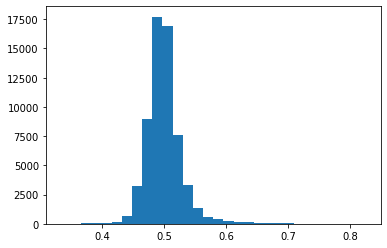

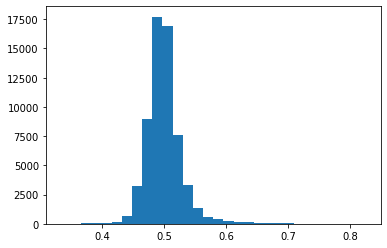

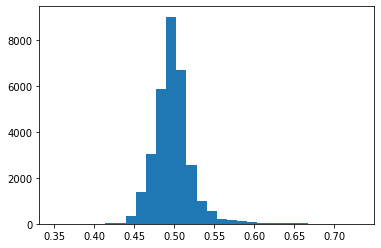

In [44]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [46]:
df_train['y_pred'] = train_pred
df_test['y_pred'] = test_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

In [48]:
df_pred = pd.concat([df_train_pred, df_test_pred], axis=0)

In [49]:
df_index_sub = df_index.loc['1994':]

In [50]:
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short

In [51]:
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [52]:
strategy.set_rebalance_period(freq='week', rebalance_weekday=1) 

2019-10-30 18:06:13,830 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:06:13,830 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD


In [54]:
tester = Tester(strategy)

In [55]:
tsrv_cum_return, tsrv_summary = tester.test_ts_signal()
csrv_cum_return, csrv_summary = tester.test_cs_signal()

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: divide by zero encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: invalid value encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: divide by zero encountered in true_divide
  csrv_port = pd.DataFrame(csrv_sig.to_numpy() / csrv_sig.sum(axis=1).values.reshape(-1, 1), columns=csrv_sig.columns, index=csrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: invalid value encountered in

In [56]:
strategy.set_portfolio_parameter(cs_strategy_type='vol')
strategy.make_portfolio()

2019-10-30 18:06:18,216 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:06:18,216 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:06:18,218 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:06:18,218 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:06:18,218 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:06:18,218 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:06:31,968 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 18:06:31,968 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 18:06:31,969 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 18:06:31,969 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 18:06:33,581 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-30 18:06:33,581 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-30 18:06:33,588 - EPM - INFO - [STEP 5 - 2 - 3] STRATEGY LEVEL VOL CONTR

### TRAIN

2019-10-30 18:06:44,264 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:06:44,264 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:06:44,265 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:06:44,265 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:06:44,274 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:06:44,274 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:06:44,283 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 18:06:44,283 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


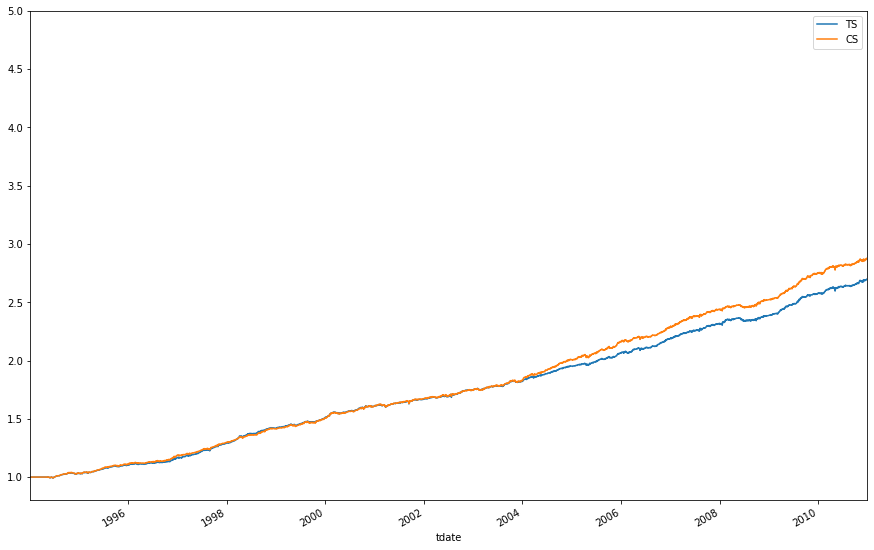

In [57]:
tester = Tester(strategy)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.8, 5))

### TEST

2019-10-30 18:06:44,436 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:06:44,436 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:06:44,437 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:06:44,437 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:06:44,444 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:06:44,444 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:06:44,451 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 18:06:44,451 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


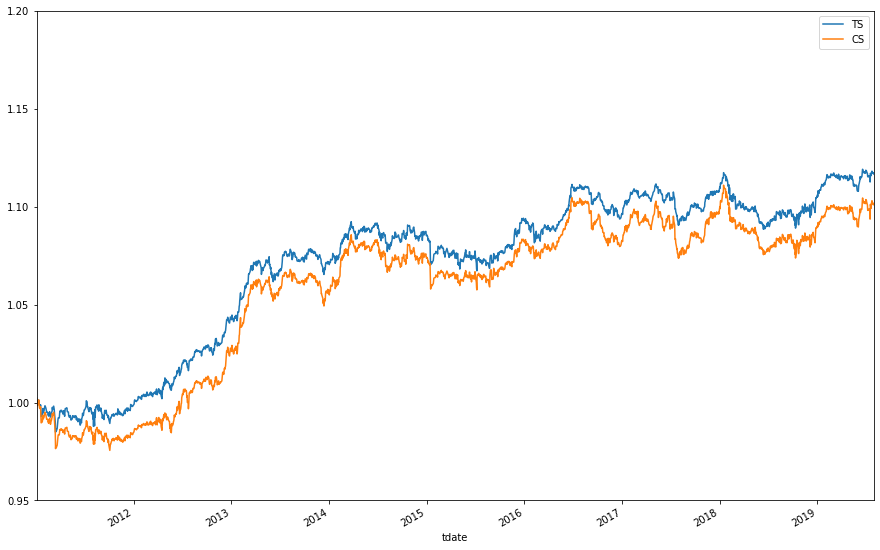

In [58]:
tester = Tester(strategy)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,ylim=(0.95, 1.2))

# CASE 2. BINARY 30% 70%


- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [68]:
one_week = 5
one_month = 20

df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

df_index_y_binary30_1 = df_index_rank > 7/10 * df_index_rank.shape[1]
df_index_y_binary30_1 = df_index_y_binary30_1.astype(np.float32)

df_index_y_binary30_2 = df_index_rank < 3/10 * df_index_rank.shape[1]
df_index_y_binary30_2 = df_index_y_binary30_2.astype(np.float32)

In [69]:
df_index_y_binary30_1 = df_index_y_binary30_1.unstack().reset_index()
df_index_y_binary30_1.columns = ['ticker', 'tdate', 'info']

df_index_y_binary30_2 = df_index_y_binary30_2.unstack().reset_index()
df_index_y_binary30_2.columns = ['ticker', 'tdate', 'info']

In [70]:
df_index_y_binary30_1 = df_index_y_binary30_1[df_index_y_binary30_1['info'] == 1]
df_index_y_binary30_2 = df_index_y_binary30_2[df_index_y_binary30_2['info'] == 1]
df_index_y_binary30 = pd.concat([df_index_y_binary30_1, df_index_y_binary30_2], axis=0)

In [71]:
df_y2 = df_index_y_binary.unstack().reset_index()
df_y2.columns = ['ticker', 'tdate', 'y']
df_y2 = pd.merge(df_y2, df_index_y_binary30, on=['ticker', 'tdate'])

In [72]:
df_join2 = pd.merge(df_y2, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_cum_ret, on=['tdate', 'ticker'])

In [73]:
df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2010-12-31')]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[4:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [75]:
model2, train_pred2, val_pred2 = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.686373	valid_1's binary_logloss: 0.686373
[20]	training's binary_logloss: 0.685852	valid_1's binary_logloss: 0.685852
[30]	training's binary_logloss: 0.685373	valid_1's binary_logloss: 0.685373
[40]	training's binary_logloss: 0.684938	valid_1's binary_logloss: 0.684938
[50]	training's binary_logloss: 0.684543	valid_1's binary_logloss: 0.684543
[60]	training's binary_logloss: 0.684166	valid_1's binary_logloss: 0.684166
[70]	training's binary_logloss: 0.683818	valid_1's binary_logloss: 0.683818
[80]	training's binary_logloss: 0.683502	valid_1's binary_logloss: 0.683502
[90]	training's binary_logloss: 0.683185	valid_1's binary_logloss: 0.683185
[100]	training's binary_logloss: 0.68289	valid_1's binary_logloss: 0.68289
[110]	training's binary_logloss: 0.682614	valid_1's binary_logloss: 0.682614
[120]	training's binary_logloss: 0.682338	valid_1's binary_logloss: 0.682338
[130]	training's binary_l

In [76]:
df_pred2 = df_join.copy()
pred2 = model2.predict(df_join[df_join.columns[3:]].values)
df_pred2['y_pred'] = pred2
df_pred2 = pd.pivot_table(df_pred2, columns='ticker', index='tdate', values='y_pred')

(array([9.0000e+00, 2.5000e+01, 2.0000e+01, 2.1000e+01, 3.4000e+01,
        6.1000e+01, 8.1000e+01, 1.0800e+02, 2.9500e+02, 1.6020e+03,
        4.3390e+03, 7.6970e+03, 1.4240e+04, 2.1200e+04, 2.1694e+04,
        1.2937e+04, 4.6860e+03, 1.6530e+03, 8.9600e+02, 5.6700e+02,
        3.2100e+02, 2.3000e+02, 1.4500e+02, 9.9000e+01, 8.9000e+01,
        6.9000e+01, 5.6000e+01, 6.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([0.31429492, 0.33165032, 0.34900572, 0.36636111, 0.38371651,
        0.40107191, 0.41842731, 0.4357827 , 0.4531381 , 0.4704935 ,
        0.4878489 , 0.50520429, 0.52255969, 0.53991509, 0.55727049,
        0.57462588, 0.59198128, 0.60933668, 0.62669208, 0.64404747,
        0.66140287, 0.67875827, 0.69611366, 0.71346906, 0.73082446,
        0.74817986, 0.76553525, 0.78289065, 0.80024605, 0.81760145,
        0.83495684]),
 <a list of 30 Patch objects>)

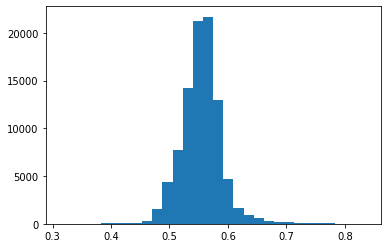

In [77]:
plt.hist(pred2, bins=30)

In [78]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3

df_pred_rank2 = df_pred2.rank(axis=1)

df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [79]:
strategy2 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy2.load_index_and_return(from_db=False, save_file=False)
strategy2.index.columns.name = 'ticker'
strategy2.ret.columns.name = 'ticker'
strategy2.index.drop_duplicates(inplace=True)
strategy2.ret.drop_duplicates(inplace=True)

2019-10-30 18:07:41,468 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:07:41,468 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:07:41,468 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:07:41,470 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:07:41,470 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:07:41,470 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:07:41,471 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:07:41,471 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:07:41,471 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [80]:
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2

strategy2.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy2.set_portfolio_parameter(cs_strategy_type='vol')
strategy2.make_portfolio()

2019-10-30 18:07:48,524 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:07:48,524 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:07:48,524 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:07:48,526 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:07:48,526 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:07:48,526 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:07:48,527 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:07:48,527 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:07:48,527 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:07:48,528 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:07:48,528 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:07:48,528 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:08:02,404 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 18:08:02,404 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 18:08:02,404 - EPM -

### TRAIN

2019-10-30 18:08:14,871 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:08:14,871 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:08:14,871 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:08:14,873 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:08:14,873 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:08:14,873 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:08:14,880 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:08:14,880 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:08:14,880 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:08:14,888 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 18:08:14,888 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 18:08:14,888 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


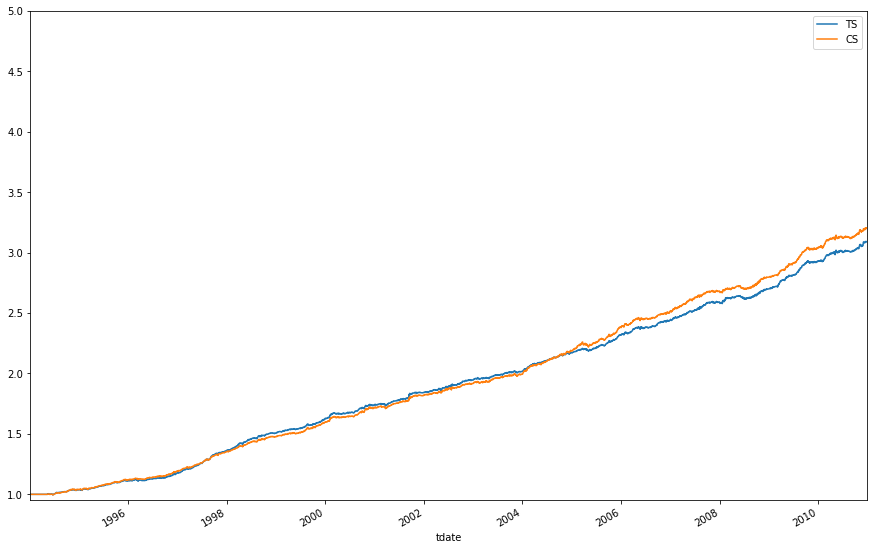

In [81]:
tester = Tester(strategy2)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 5))

### TEST

2019-10-30 18:08:15,048 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:08:15,048 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:08:15,048 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:08:15,050 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:08:15,050 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:08:15,050 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:08:15,058 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:08:15,058 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:08:15,058 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:08:15,067 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 18:08:15,067 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 18:08:15,067 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


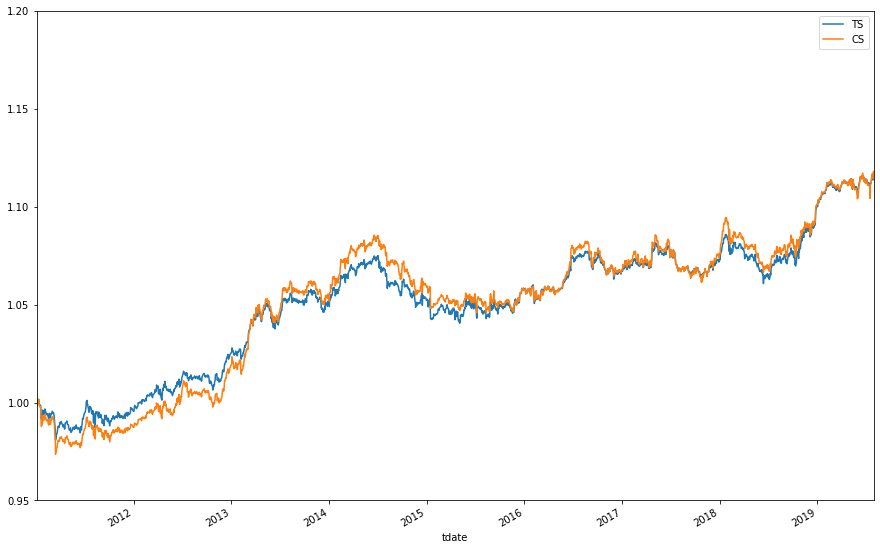

In [82]:
tester = Tester(strategy2)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 1.2))

# CASE 3. Case1을 Rolling으로 실행

In [83]:
rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [84]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [85]:
models = []
train_preds = []
test_preds = []

In [86]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692832	valid_1's binary_logloss: 0.692894
[20]	training's binary_logloss: 0.692544	valid_1's binary_logloss: 0.692729
[30]	training's binary_logloss: 0.692288	valid_1's binary_logloss: 0.692582
[40]	training's binary_logloss: 0.692063	valid_1's binary_logloss: 0.692462
[50]	training's binary_logloss: 0.691856	valid_1's binary_logloss: 0.692394
[60]	training's binary_logloss: 0.69167	valid_1's binary_logloss: 0.692291
[70]	training's binary_logloss: 0.691472	valid_1's binary_logloss: 0.692184
[80]	training's binary_logloss: 0.691289	valid_1's binary_logloss: 0.692097
[90]	training's binary_logloss: 0.691112	valid_1's binary_logloss: 0.692053
[100]	training's binary_logloss: 0.69094	valid_1's binary_logloss: 0.692027
[110]	training's binary_logloss: 0.69078	valid_1's binary_logloss: 0.692019
[120]	training's binary_logloss: 0.690622	valid_1's binary_logloss: 0.691974
[130]	training's binary_lo

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.69282	valid_1's binary_logloss: 0.692942
[20]	training's binary_logloss: 0.692534	valid_1's binary_logloss: 0.692793
[30]	training's binary_logloss: 0.692279	valid_1's binary_logloss: 0.692718
[40]	training's binary_logloss: 0.692049	valid_1's binary_logloss: 0.692611
[50]	training's binary_logloss: 0.69184	valid_1's binary_logloss: 0.692586
[60]	training's binary_logloss: 0.691656	valid_1's binary_logloss: 0.69253
[70]	training's binary_logloss: 0.691485	valid_1's binary_logloss: 0.692471
[80]	training's binary_logloss: 0.691322	valid_1's binary_logloss: 0.692414
[90]	training's binary_logloss: 0.691153	valid_1's binary_logloss: 0.692364
[100]	training's binary_logloss: 0.690994	valid_1's binary_logloss: 0.692352
[110]	training's binary_logloss: 0.690838	valid_1's binary_logloss: 0.69232
[120]	training's binary_logloss: 0.690687	valid_1's binary_logloss: 0.692286
[130]	training's binary_log

[130]	training's binary_logloss: 0.690741	valid_1's binary_logloss: 0.692503
[140]	training's binary_logloss: 0.6906	valid_1's binary_logloss: 0.692491
[150]	training's binary_logloss: 0.690469	valid_1's binary_logloss: 0.692485
[160]	training's binary_logloss: 0.690342	valid_1's binary_logloss: 0.692508
[170]	training's binary_logloss: 0.690207	valid_1's binary_logloss: 0.692509
[180]	training's binary_logloss: 0.690072	valid_1's binary_logloss: 0.692498
[190]	training's binary_logloss: 0.689947	valid_1's binary_logloss: 0.692483
[200]	training's binary_logloss: 0.68982	valid_1's binary_logloss: 0.69249
[210]	training's binary_logloss: 0.689693	valid_1's binary_logloss: 0.692474
[220]	training's binary_logloss: 0.689568	valid_1's binary_logloss: 0.692429
[230]	training's binary_logloss: 0.68944	valid_1's binary_logloss: 0.692444
[240]	training's binary_logloss: 0.689322	valid_1's binary_logloss: 0.692439
[250]	training's binary_logloss: 0.689201	valid_1's binary_logloss: 0.692433
[260

[170]	training's binary_logloss: 0.690408	valid_1's binary_logloss: 0.693199
[180]	training's binary_logloss: 0.690273	valid_1's binary_logloss: 0.693228
[190]	training's binary_logloss: 0.690127	valid_1's binary_logloss: 0.693235
[200]	training's binary_logloss: 0.689996	valid_1's binary_logloss: 0.693247
[210]	training's binary_logloss: 0.689877	valid_1's binary_logloss: 0.693214
[220]	training's binary_logloss: 0.689758	valid_1's binary_logloss: 0.693199
[230]	training's binary_logloss: 0.689643	valid_1's binary_logloss: 0.693202
[240]	training's binary_logloss: 0.68953	valid_1's binary_logloss: 0.69323
[250]	training's binary_logloss: 0.689432	valid_1's binary_logloss: 0.693237
[260]	training's binary_logloss: 0.689336	valid_1's binary_logloss: 0.693241
[270]	training's binary_logloss: 0.689226	valid_1's binary_logloss: 0.693256
[280]	training's binary_logloss: 0.689116	valid_1's binary_logloss: 0.693242
[290]	training's binary_logloss: 0.68901	valid_1's binary_logloss: 0.693234
[3

[310]	training's binary_logloss: 0.689301	valid_1's binary_logloss: 0.693092
[320]	training's binary_logloss: 0.689207	valid_1's binary_logloss: 0.693092
[330]	training's binary_logloss: 0.689116	valid_1's binary_logloss: 0.693107
[340]	training's binary_logloss: 0.689018	valid_1's binary_logloss: 0.693164
[350]	training's binary_logloss: 0.688926	valid_1's binary_logloss: 0.693156
[360]	training's binary_logloss: 0.688828	valid_1's binary_logloss: 0.693169
[370]	training's binary_logloss: 0.688732	valid_1's binary_logloss: 0.693194
[380]	training's binary_logloss: 0.688644	valid_1's binary_logloss: 0.693265
[390]	training's binary_logloss: 0.688556	valid_1's binary_logloss: 0.693289
[400]	training's binary_logloss: 0.688456	valid_1's binary_logloss: 0.693346
[410]	training's binary_logloss: 0.688371	valid_1's binary_logloss: 0.693425
[420]	training's binary_logloss: 0.688286	valid_1's binary_logloss: 0.69351
[430]	training's binary_logloss: 0.688206	valid_1's binary_logloss: 0.693582


In [87]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([9.000e+00, 2.000e+00, 1.300e+01, 1.600e+01, 4.800e+01, 2.570e+02,
        9.890e+02, 1.564e+03, 4.395e+03, 8.351e+03, 7.698e+03, 4.327e+03,
        1.658e+03, 7.540e+02, 4.410e+02, 2.240e+02, 1.380e+02, 1.250e+02,
        6.700e+01, 7.200e+01, 2.600e+01, 2.500e+01, 2.500e+01, 2.000e+01,
        1.300e+01, 1.300e+01, 8.000e+00, 4.000e+00, 5.000e+00, 3.000e+00]),
 array([0.39213735, 0.40247412, 0.41281089, 0.42314766, 0.43348443,
        0.4438212 , 0.45415797, 0.46449473, 0.4748315 , 0.48516827,
        0.49550504, 0.50584181, 0.51617858, 0.52651535, 0.53685212,
        0.54718889, 0.55752566, 0.56786243, 0.5781992 , 0.58853597,
        0.59887274, 0.60920951, 0.61954628, 0.62988305, 0.64021982,
        0.65055659, 0.66089336, 0.67123013, 0.6815669 , 0.69190367,
        0.70224044]),
 <a list of 30 Patch objects>)

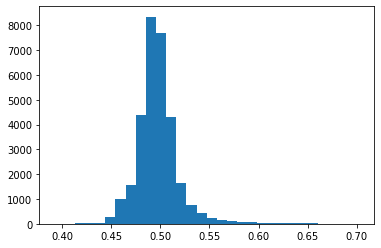

In [88]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [89]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [90]:
strategy3 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy3.load_index_and_return(from_db=False, save_file=False)
strategy3.index.columns.name = 'ticker'
strategy3.ret.columns.name = 'ticker'
strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

2019-10-30 18:08:23,481 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:08:23,481 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:08:23,481 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:08:23,481 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:08:23,484 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:08:23,484 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:08:23,484 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:08:23,484 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:08:23,485 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:08:23,485 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:08:23,485 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:08:23,485 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [91]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy3.set_portfolio_parameter(cs_strategy_type='vol')
strategy3.make_portfolio()

2019-10-30 18:08:23,528 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:08:23,528 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:08:23,528 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:08:23,528 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:08:23,530 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:08:23,530 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:08:23,530 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:08:23,530 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:08:23,532 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:08:23,532 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:08:23,532 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:08:23,532 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:08:23,534 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:08:23,534 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:08:23,534 - EPM - INFO -

2019-10-30 18:08:41,512 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:08:41,512 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:08:41,512 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:08:41,512 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:08:41,514 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:08:41,514 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:08:41,514 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:08:41,514 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:08:41,525 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:08:41,525 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:08:41,525 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:08:41,525 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:08:41,535 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 18:08:41,535 - EPM - INFO - [STEP 7]

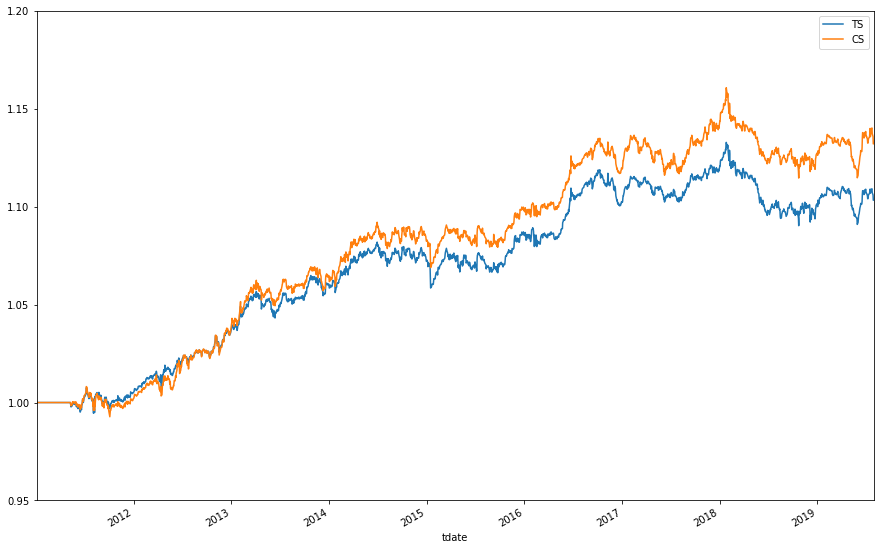

In [92]:
tester = Tester(strategy3)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 1.2))

# CASE 4. CASE 2를 ROLLING으로 실행

In [93]:
models = []
train_preds = []
test_preds = []

In [94]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.686373	valid_1's binary_logloss: 0.699291
[20]	training's binary_logloss: 0.685852	valid_1's binary_logloss: 0.699224
[30]	training's binary_logloss: 0.685373	valid_1's binary_logloss: 0.699423
[40]	training's binary_logloss: 0.684938	valid_1's binary_logloss: 0.699671
[50]	training's binary_logloss: 0.684543	valid_1's binary_logloss: 0.699772
[60]	training's binary_logloss: 0.684166	valid_1's binary_logloss: 0.699975
[70]	training's binary_logloss: 0.683818	valid_1's binary_logloss: 0.700286
[80]	training's binary_logloss: 0.683502	valid_1's binary_logloss: 0.700442
[90]	training's binary_logloss: 0.683185	valid_1's binary_logloss: 0.700661
[100]	training's binary_logloss: 0.68289	valid_1's binary_logloss: 0.700683
[110]	training's binary_logloss: 0.682614	valid_1's binary_logloss: 0.700644
[120]	training's binary_logloss: 0.682338	valid_1's binary_logloss: 0.700508
[130]	training's binary_

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[10]	training's binary_logloss: 0.686369	valid_1's binary_logloss: 0.699202
[20]	training's binary_logloss: 0.685836	valid_1's binary_logloss: 0.699091
[30]	training's binary_logloss: 0.685369	valid_1's binary_logloss: 0.699031
[40]	training's binary_logloss: 0.684937	valid_1's binary_logloss: 0.698976
[50]	training's binary_logloss: 0.684563	valid_1's binary_logloss: 0.698903
[60]	training's binary_logloss: 0.684202	valid_1's binary_logloss: 0.69888
[70]	training's binary_logloss: 0.683871	valid_1's binary_logloss: 0.698862
[80]	training's binary_logloss: 0.683578	valid_1's binary_logloss: 0.698912
[90]	training's binary_logloss: 0.683296	valid_1's binary_logloss: 0.698946
[100]	training's binary_logloss: 0.683027	valid_1's binary_logloss: 0.699013
[110]	training's binary_logloss: 0.68276	valid_1's binary_logloss: 0.69897
[120]	training's binary_logloss: 0.682499	valid_1's binary_logloss: 0.699006
[130]	training's binary_logloss: 0.682249	valid_1's binary_logloss: 0.698956
[140]	trai

[170]	training's binary_logloss: 0.681816	valid_1's binary_logloss: 0.698934
[180]	training's binary_logloss: 0.6816	valid_1's binary_logloss: 0.699059
[190]	training's binary_logloss: 0.681369	valid_1's binary_logloss: 0.699129
[200]	training's binary_logloss: 0.68115	valid_1's binary_logloss: 0.698797
[210]	training's binary_logloss: 0.680938	valid_1's binary_logloss: 0.698771
[220]	training's binary_logloss: 0.680738	valid_1's binary_logloss: 0.698701
[230]	training's binary_logloss: 0.680538	valid_1's binary_logloss: 0.698449
[240]	training's binary_logloss: 0.680323	valid_1's binary_logloss: 0.69849
[250]	training's binary_logloss: 0.680137	valid_1's binary_logloss: 0.698417
[260]	training's binary_logloss: 0.679951	valid_1's binary_logloss: 0.698493
[270]	training's binary_logloss: 0.679753	valid_1's binary_logloss: 0.698328
[280]	training's binary_logloss: 0.679536	valid_1's binary_logloss: 0.697778
[290]	training's binary_logloss: 0.67936	valid_1's binary_logloss: 0.697695
[300

[400]	training's binary_logloss: 0.677893	valid_1's binary_logloss: 0.697186
[410]	training's binary_logloss: 0.677723	valid_1's binary_logloss: 0.69692
[420]	training's binary_logloss: 0.677577	valid_1's binary_logloss: 0.697045
[430]	training's binary_logloss: 0.677401	valid_1's binary_logloss: 0.696986
[440]	training's binary_logloss: 0.677243	valid_1's binary_logloss: 0.69701
[450]	training's binary_logloss: 0.677105	valid_1's binary_logloss: 0.696988
[460]	training's binary_logloss: 0.676938	valid_1's binary_logloss: 0.696904
[470]	training's binary_logloss: 0.676788	valid_1's binary_logloss: 0.696966
[480]	training's binary_logloss: 0.676634	valid_1's binary_logloss: 0.696857
[490]	training's binary_logloss: 0.676469	valid_1's binary_logloss: 0.696792
[500]	training's binary_logloss: 0.676326	valid_1's binary_logloss: 0.696816
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.676326	valid_1's binary_logloss: 0.696816
Training until validation scor

Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.686504	valid_1's binary_logloss: 0.702974
[20]	training's binary_logloss: 0.686106	valid_1's binary_logloss: 0.702799
[30]	training's binary_logloss: 0.685752	valid_1's binary_logloss: 0.702828
[40]	training's binary_logloss: 0.685417	valid_1's binary_logloss: 0.702671
[50]	training's binary_logloss: 0.685129	valid_1's binary_logloss: 0.702419
[60]	training's binary_logloss: 0.684868	valid_1's binary_logloss: 0.702302
[70]	training's binary_logloss: 0.684624	valid_1's binary_logloss: 0.702232
[80]	training's binary_logloss: 0.684387	valid_1's binary_logloss: 0.702304
[90]	training's binary_logloss: 0.684155	valid_1's binary_logloss: 0.702288
[100]	training's binary_logloss: 0.683936	valid_1's binary_logloss: 0.702269
[110]	training's binary_logloss: 0.683727	valid_1's binary_logloss: 0.70234
[120]	training's binary_logloss: 0.683523	valid_1's binary_logloss: 0.702541
[130]	training's binary_

In [95]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [96]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [97]:
strategy4 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy4.load_index_and_return(from_db=False, save_file=False)
strategy4.index.columns.name = 'ticker'
strategy4.ret.columns.name = 'ticker'
strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

2019-10-30 18:08:47,478 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:08:47,478 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:08:47,478 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:08:47,478 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:08:47,478 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:08:47,482 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:08:47,482 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:08:47,482 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:08:47,482 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:08:47,482 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:08:47,484 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:08:47,484 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:08:47,484 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:08:47,484 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:08:47,484 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [98]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy4.set_portfolio_parameter(cs_strategy_type='vol')
strategy4.make_portfolio()

2019-10-30 18:08:47,532 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:08:47,532 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:08:47,532 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:08:47,532 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:08:47,532 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:08:47,534 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:08:47,534 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:08:47,534 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:08:47,534 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:08:47,534 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:08:47,535 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:08:47,535 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:08:47,535 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:08:47,535 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:08:47,535 - EPM - INFO - [STE

2019-10-30 18:09:05,492 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:09:05,492 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:09:05,492 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:09:05,492 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:09:05,492 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:09:05,494 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:09:05,494 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:09:05,494 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:09:05,494 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:09:05,494 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:09:05,503 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:09:05,503 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:09:05,503 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:09:05,503 - EPM - INFO - [STEP 6 - 2] BACKT

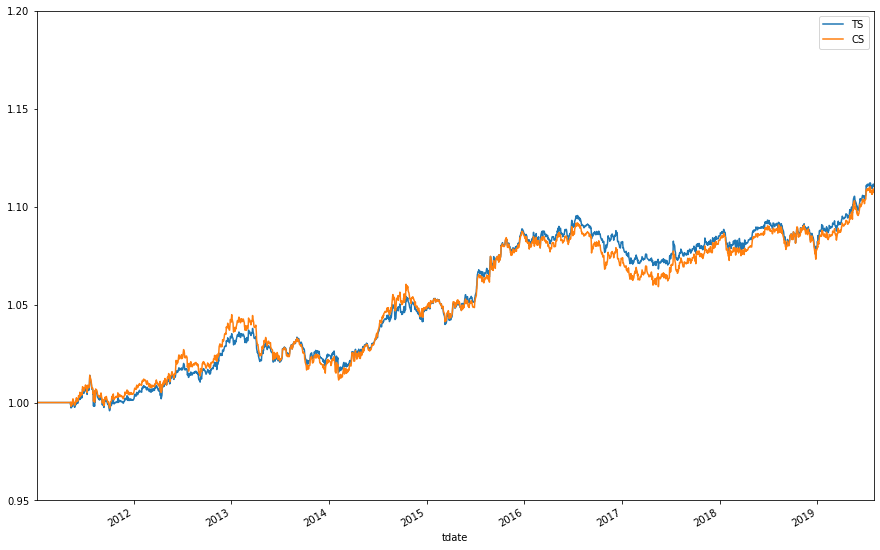

In [99]:
tester = Tester(strategy4)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 1.2))